# get woe value

In [1]:
#Load Required Packages
import pandas as pd
import numpy as np
import woe.feature_process as fp
import woe.eval as eval
 
#Implement sigmoid function    
def sigmoid(x):
    return 1/(1 + np.exp(-x))

 # using woe package
def iv_woe(data, target, feature):
    #save all woe value
    data_woe = data 
    civ_list = []
    n_positive = sum(data[target])
    n_negtive = len(data[target]) - n_positive
    cols = data.columns
    for column in cols[~cols.isin(['target'])]:
        if column == feature:
            if (data[column].dtype.kind in 'bifc') and (len(np.unique(data[column]))>10):
                civ = fp.proc_woe_continuous(data, column, n_positive, n_negtive, 0.05*len(data), alpha=0.01)
                civ_list.append(civ)
                data_woe[column] = fp.woe_trans(data[column], civ)
                civ_df = eval.eval_feature_detail(civ_list,'output_feature_detail_0315.csv')
            
                print(civ_df[['var_name', 'split_list', 'woe_list']])
                woeval = civ_df['woe_list']
                
            else:  
                woeval = iv_woe2(df, 'target', 'Ethnicity')          
               
           
    return woeval, len(woeval)

#when value is discrete
def iv_woe2(data, target, feature):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    #print(type(feature))
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if ivars == feature:
            #value is continuous
            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                #binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                binned_x = pd.cut(data[ivars], bins)
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
                print('value is continuous')
            else:#value is discrete
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
                print('value is discrete')
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
            d['Non-Events'] = d['N'] - d['Events']
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)
            #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)

    return d['WoE']

# plot woe distribution

In [2]:
import matplotlib.pyplot as plt  

def plot_woe(numbin, woe_value, feature, class_, X):
    """
    Plot the probability distribution of a class based on the feature
    """
    s=numbin+1
    # Get the segment
    vals = range(1,s) 

     # Get the column number of the feature
    j = features.index(feature)
  
    # Get the unique feature values and their indices
    ufvals= np.unique(X[:, j])
    ufvals = np.round(ufvals, 2)

    # Get the probabilities
    probas = woe_value 
    
    # Get the pandas dataframe
    df = pd.DataFrame(list(zip(vals, probas)), columns=[feature, 'Probability'])
    
    dic = dict({'w25698': 'software', 'w30360': 'year', 'w21347': 'people','w41': 'feature14', 'w42': 'column 15','MDVP:Fo(Hz)': 'MDVP:Fo(Hz)',
             'Jitter:DDP':'Jitter:DDP','char_freq_!':'char_freq_!','word_freq_address': 'word_freq_address',
              'H3K36me3_c12':'H3K36me3_c12','H3K36me3_c14c': 'H3K36me3_c14c', 'YY1': 'YY1',
             'PPE':'PPE','EP300_body_Stanford':'EP300_body_Stanford','MXI1_body_ENCODE':'MXI1_body_ENCODE','MAFK_body_Stanford':'MAFK_body_Stanford','MYC_body_UTA':'MYC_body_UTA'
             ,'10-15B':'10-15B','H3K79me2_body_Broad':'H3K79me2_body_Broad','H3K9ac':'H3K9ac','16-16R':'16-16R'}) 
    
    # Plot the histogram
    df.plot(x=feature,
            y='Probability',
            kind='bar',
            yticks=[0, 0.25, 0.5, 0.75, 1],
            ylim=(0, 1),
            figsize=(10, 5),
            title=class_,
            legend=False,
            fontsize=30,
            color='g',
            rot=0
             )
    
    m = len(ufvals)
    mid = m//2
    a=[1,2,3]
    a[0]=ufvals[0]
    a[1]=ufvals[mid]
    a[2]=ufvals[m-1]
    n = len(vals)
    print(n)
    if feature!='Ethnicity':
        if n == 2:
            plt.xticks([0, n - 1], [a[0], a[2]], fontsize=30, rotation=0)
        elif n==1:
            plt.xticks([0],[a[1]], fontsize=30, rotation=0)
        else:
            mid = n // 2
            # Only show the min, average, and max
            plt.xticks([0, mid, n - 1], [a[0], a[1], a[2]], fontsize=30, rotation=0)
    
    if feature.isalpha():
        plt.xlabel(feature, fontsize=30)
    else:
        plt.xlabel(dic[feature], fontsize=30)
        
    plt.ylabel('Probability', fontsize=30)
    plt.title('WOE', fontsize=30)
    plt.tight_layout()

# parkinsons

In [3]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('parkinsons.data', header=1)

# Specify the name of the columns
df.columns = ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'target', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']
# Specify the name of the features
features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)' ,'MDVP:RAP' ,'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

df.drop('name', axis=1, inplace=True)

# Get the features
X = df[features].values
# Get the target
y = df['target'].values

from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = ['target','MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

--------------process continuous variable:PPE---------------
PPE
  var_name                                  split_list  woe_list
0      PPE                  (-INF,-1.1366992770110425] -4.203353
1      PPE   (-1.1366992770110425,-1.0030571571086448]  0.391633
2      PPE   (-1.0030571571086448,-0.8036357388974439] -2.721804
3      PPE   (-0.8036357388974439,-0.6527504069734439]  1.190089
4      PPE   (-0.6527504069734439,-0.5040921324089773] -0.265127
5      PPE   (-0.5040921324089773,-0.3925701588338044]  0.496992
6      PPE  (-0.3925701588338044,-0.24224339793343236] -0.706949
7      PPE  (-0.24224339793343236,0.10893167220466192]  0.784686
8      PPE                  (0.10893167220466192,+INF)  3.281945
9


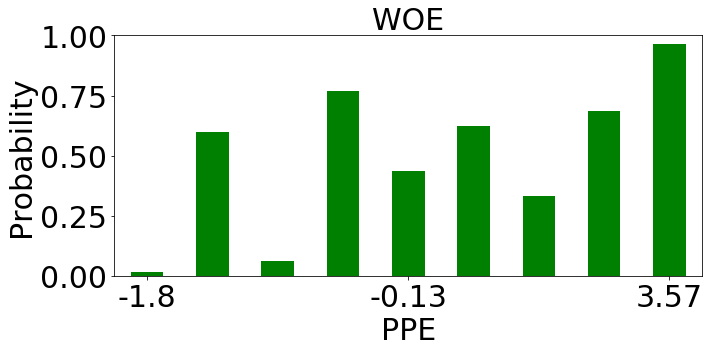

In [4]:
woev, numbin = iv_woe(dff, 'target', 'PPE')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'PPE', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-parkinsons.png', dpi=300)
plt.show()

# drug consumption

In [5]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('drug_consumption.csv', header=None)

# Specify the name of the columns
df.columns = ['ID', 'Age', 'Gender', 'Education', 'Country','Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore','Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet','Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack','Ecstasy', 'target', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']
features = ['ID', 'Age', 'Gender', 'Education', 'Country','Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore','Cscore', 'Impulsive', 'SS']

# Get the features
X = df[features].values

# Get the target
y = df['target'].values

for i in range(0,1885):
    if not y[i] == 'CL0' :
        y[i] = 'CL7'
    if y[i] == 'CL0':
        y[i] = 0
    else:
        y[i] = 1
        
from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = ['target','ID', 'Age', 'Gender', 'Education', 'Country','Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore','Cscore', 'Impulsive', 'SS']

value is discrete
7


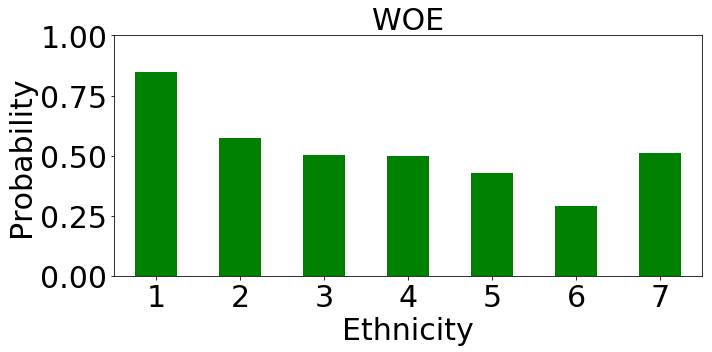

In [6]:
woev, numbin = iv_woe(dff, 'target', 'Ethnicity')
swoe = sigmoid(woev)
swoe=1-swoe
#print(swoe)
plot_woe(numbin, swoe,  'Ethnicity', 0, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-drug.png', dpi=300)
plt.show()

# drosophila_enhancers

In [7]:
import pandas as pd

# Load the data
df = pd.read_csv('drosophila_enhancers.csv', header=1)

# Specify the name of the columns
df.columns = ['target','H3_c12','H3_c14a','H3_c14c','H3_c8','H3K18ac_c12','H3K18ac_c14a','H3K18ac_c14c',
              'H3K18ac_c8','H3K27ac_c12','H3K27ac_c14a','H3K27ac_c14c','H3K27ac_c8','H3K27me3_c12','H3K27me3_c14a','H3K27me3_c14c','H3K36me3_c12',
              'H3K36me3_c14a','H3K36me3_c14c','H3K4me1_c12','H3K4me1_c14a','H3K4me1_c14c','H3K4me1_c8','H3K4me3_c12','H3K4me3_c14a','H3K4me3_c14c',
              'H3K4me3_c8','H3K9ac_c12','H3K9ac_c14a','H3K9ac_c14c','H3K9ac_c8','H4K5ac_c12','H4K5ac_c14a','H4K5ac_c14c','H4K5ac_c8','H4K8ac_c12',
              'H4K8ac_c14a','H4K8ac_c14c','H4K8ac_c8','input_c12','input_c14a','input_c14c','input_c8','wt_H3','wt_H3K18ac','wt_H3K4me1','wt_ZLD','bcd1',
              'bcd2','cad1','D1','da2','dl3','ftz3','gt2','h1','h2','hb1','hb2','hkb1','hkb2','hkb3','kni1','kni2','kr1','kr2','mad2','med2','prdBQ','prdFQ',
              'run1','run2','shn2','shn3','slp1','sna1','sna2','tll1','twi1','twi2','z2']

# Features
features = ['H3_c12','H3_c14a','H3_c14c','H3_c8','H3K18ac_c12','H3K18ac_c14a','H3K18ac_c14c',
              'H3K18ac_c8','H3K27ac_c12','H3K27ac_c14a','H3K27ac_c14c','H3K27ac_c8','H3K27me3_c12','H3K27me3_c14a','H3K27me3_c14c','H3K36me3_c12',
              'H3K36me3_c14a','H3K36me3_c14c','H3K4me1_c12','H3K4me1_c14a','H3K4me1_c14c','H3K4me1_c8','H3K4me3_c12','H3K4me3_c14a','H3K4me3_c14c',
              'H3K4me3_c8','H3K9ac_c12','H3K9ac_c14a','H3K9ac_c14c','H3K9ac_c8','H4K5ac_c12','H4K5ac_c14a','H4K5ac_c14c','H4K5ac_c8','H4K8ac_c12',
              'H4K8ac_c14a','H4K8ac_c14c','H4K8ac_c8','input_c12','input_c14a','input_c14c','input_c8','wt_H3','wt_H3K18ac','wt_H3K4me1','wt_ZLD','bcd1',
              'bcd2','cad1','D1','da2','dl3','ftz3','gt2','h1','h2','hb1','hb2','hkb1','hkb2','hkb3','kni1','kni2','kr1','kr2','mad2','med2','prdBQ','prdFQ',
              'run1','run2','shn2','shn3','slp1','sna1','sna2','tll1','twi1','twi2','z2']
# Get the features
X = df[features].values
y = df['target'].values
from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = ['target','H3_c12','H3_c14a','H3_c14c','H3_c8','H3K18ac_c12','H3K18ac_c14a','H3K18ac_c14c',
              'H3K18ac_c8','H3K27ac_c12','H3K27ac_c14a','H3K27ac_c14c','H3K27ac_c8','H3K27me3_c12','H3K27me3_c14a','H3K27me3_c14c','H3K36me3_c12',
              'H3K36me3_c14a','H3K36me3_c14c','H3K4me1_c12','H3K4me1_c14a','H3K4me1_c14c','H3K4me1_c8','H3K4me3_c12','H3K4me3_c14a','H3K4me3_c14c',
              'H3K4me3_c8','H3K9ac_c12','H3K9ac_c14a','H3K9ac_c14c','H3K9ac_c8','H4K5ac_c12','H4K5ac_c14a','H4K5ac_c14c','H4K5ac_c8','H4K8ac_c12',
              'H4K8ac_c14a','H4K8ac_c14c','H4K8ac_c8','input_c12','input_c14a','input_c14c','input_c8','wt_H3','wt_H3K18ac','wt_H3K4me1','wt_ZLD','bcd1',
              'bcd2','cad1','D1','da2','dl3','ftz3','gt2','h1','h2','hb1','hb2','hkb1','hkb2','hkb3','kni1','kni2','kr1','kr2','mad2','med2','prdBQ','prdFQ',
              'run1','run2','shn2','shn3','slp1','sna1','sna2','tll1','twi1','twi2','z2']

---------process continuous variable:H3K36me3_c14c----------
H3K36me3_c14c
        var_name                                split_list  woe_list
0  H3K36me3_c14c                (-INF,-0.6914529464193343] -0.133016
1  H3K36me3_c14c  (-0.6914529464193343,0.7037787638966247]  0.014728
2  H3K36me3_c14c                 (0.7037787638966247,+INF) -0.013387
3


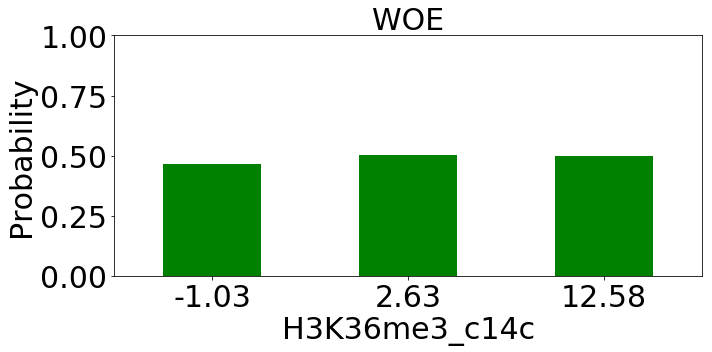

In [8]:
woev, numbin = iv_woe(dff, 'target', 'H3K36me3_c14c')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'H3K36me3_c14c', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-drosophila.png', dpi=300)
plt.show()

# alternative_splicing

In [9]:
import pandas as pd
import numpy as np


# Load the data
df = pd.read_csv('alternative_splicing.csv', header=1)

# Specify the name of the columns
df.columns = ['target','MYC_body_UTA','CTCF_body_UTA','POLR2A_body_UTA','ARID3A_body_Stanford','ATF1_body_HMS','ATF3_body_HMS','BACH1_body_Stanford',
              'BDP1_body_HMS','BHLHE40_body_Stanford','BRF1_body_HMS','BRF2_body_HMS','SMARCA4_body_Stanford','CCNT2_body_HMS','CUX1_body_Stanford',
              'FOS_body_Yale','CEBPB_body_Stanford','CHD2_body_Stanford','JUN_body_Stanford','JUN_body_Yale','JUN_body_Yale.1','JUN_body_Yale.2',
              'JUN_body_Stanford.1','JUN_body_Yale.3','MYC_body_Yale','MYC_body_Yale.1','MYC_body_Stanford','MYC_body_Yale.2','MYC_body_Stanford.1',
              'MYC_body_Yale.3','RCOR1_body_Stanford','RCOR1_body_Stanford.1','E2F4_body_USC','CTCF_body_Stanford','E2F6_body_USC','ELK1_body_Stanford',
              'GATA1_body_USC','GATA1_body_Stanford','GATA2_body_USC','GTF2B_body_HMS','GTF2F1_body_Stanford','HCFC1_body_Stanford','HMGN3_body_HMS',
              'SMARCB1_body_Stanford','IRF1_body_Stanford','IRF1_body_Stanford.1','IRF1_body_Stanford.2','IRF1_body_Stanford.3','TRIM28_body_USC','JUND_body_Stanford',
              'MAFF_body_Stanford','MAFK_body_Stanford','MAX_body_Stanford','MAX_body_Yale','MXI1_body_Stanford','NFE2_body_Yale','NFYA_body_Stanford','NFYB_body_Stanford',
              'NRF1_body_Stanford','EP300_body_Stanford','EP300_body_Stanford.1','POLR2A_body_Yale','POLR2A_body_Yale.1','POLR2A_body_Stanford',
              'POLR2A_body_Yale.2','POLR2A_body_Stanford.1','POLR2A_body_Yale.3','POLR2AphosphoS2_body_Stanford','POLR2AphosphoS2_body_Stanford.1','POLR3G_body_Stanford',
              'RAD21_body_Yale','RFX5_body_Stanford','POLR3A_body_HMS','SETDB1_body_USC','SETDB1_body_USC.1','SIRT6_body_HMS','STAT1_body_Yale','SMC3_body_Stanford',
              'STAT1_body_Yale.1','STAT1_body_Stanford','STAT1_body_Stanford.1','STAT2_body_Yale','STAT2_body_Yale.1','TAL1_body_Stanford','TBL1XR1_body_Stanford','TBL1XR1_body_Stanford.1',
              'TBP_body_Stanford','GTF3C2_body_HMS','NR2C2_body_USC','UBTF_body_Stanford','UBTF_body_Stanford.1','USF2_body_Stanford','XRCC4_body_Yale','YY1',
              'ZNF143_body_Stanford','ZNF263_body_USC','ZNF274_body_USC','ZNF274_body_USC.1','ZNF384_body_Stanford','ZMIZ1_body_Stanford','eGFP.FOS_body_UChicago',
              'eGFP.GATA2_body_UChicago','eGFP.HDAC8_body_UChicago','eGFP.JUNB_body_UChicago','eGFP.JUND_body_UChicago','eGFP.NR4A1_body_UChicago','CTCF_body_UW',
              'CTCF_body_UW.1','CHD1_body_ENCODE','CTCF_body_ENCODE','EZH2_body_ENCODE','HDAC1_body_ENCODE','HDAC2_body_ENCODE','HDAC6_body_ENCODE','EP300_body_ENCODE',
              'PHF8_body_ENCODE','KDM5B_body_ENCODE','POLR2A_body_ENCODE','RBBP5_body_ENCODE','SAP30_body_ENCODE','ATF3_body_ENCODE','BCL3_body_ENCODE','CBX3_body_ENCODE',
              'CEBPB_body_ENCODE','CTCF_body_ENCODE.1','CTCFL_body_ENCODE','E2F6_body_ENCODE','EGR1_body_ENCODE','ELF1_body_ENCODE','ETS1_body_ENCODE','FOSL1_body_ENCODE',
              'GABPA_body_ENCODE','GATA2_body_ENCODE','HDAC2_body_ENCODE.1','MAX_body_ENCODE','MEF2A_body_ENCODE','NR2F2_body_ENCODE','REST_body_ENCODE','PML_body_ENCODE',
              'POLR2AphosphoS5_body_ENCODE','POLR2A_body_ENCODE.1','SPI1_body_ENCODE','RAD21_body_ENCODE','SIN3A_body_ENCODE','SIX5_body_ENCODE',
              'SP1_body_ENCODE','SP2_body_ENCODE','SRF_body_ENCODE','STAT5A_body_ENCODE','TAF1_body_ENCODE','TAF7_body_ENCODE','TEAD4_body_ENCODE','THAP1_body_ENCODE',
              'USF1_body_ENCODE','YY1_body_ENCODE','YY1_body_ENCODE.1','ZBTB33_body_ENCODE','ZBTB7A_body_ENCODE','ARID3A_body_ENCODE','ATF1_body_ENCODE','ATF3_body_ENCODE.1',
              'BACH1_body_ENCODE','BDP1_body_ENCODE','BHLHE40_body_ENCODE','BRF1_body_ENCODE','BRF2_body_ENCODE','SMARCA4_body_ENCODE','CCNT2_body_ENCODE',
              'CEBPB_body_ENCODE.1','FOS_body_ENCODE','CHD2_body_ENCODE','JUN_body_ENCODE','JUN_body_ENCODE.1','JUN_body_ENCODE.2','JUN_body_ENCODE.3',
              'JUN_body_ENCODE.4','MYC_body_ENCODE','MYC_body_ENCODE.1','MYC_body_ENCODE.2','MYC_body_ENCODE.3','MYC_body_ENCODE.4','MYC_body_ENCODE.5',
              'RCOR1_body_ENCODE','RCOR1_body_ENCODE.1','CTCF_body_ENCODE.2','E2F4_body_ENCODE','E2F6_body_ENCODE.1','ELK1_body_ENCODE','GATA1_body_ENCODE',
              'GATA2_body_ENCODE.1','GTF2B_body_ENCODE','GTF2F1_body_ENCODE','HMGN3_body_ENCODE','SMARCB1_body_ENCODE','IRF1_body_ENCODE','IRF1_body_ENCODE.1',
              'IRF1_body_ENCODE.2','IRF1_body_ENCODE.3','JUND_body_ENCODE','TRIM28_body_ENCODE','MAFF_body_ENCODE','MAFK_body_ENCODE','MAX_body_ENCODE.1',
              'MXI1_body_ENCODE','NFE2_body_ENCODE','NFYA_body_ENCODE','NFYB_body_ENCODE','NRF1_body_ENCODE','EP300_body_ENCODE.1','POLR2A_body_ENCODE.2','POLR2A_body_ENCODE.3',
              'POLR2A_body_ENCODE.4','POLR2A_body_ENCODE.5','POLR2A_body_ENCODE.6','POLR2A_body_ENCODE.7','POLR2AphosphoS2_body_ENCODE','POLR3G_body_ENCODE','RAD21_body_ENCODE.1',
              'RFX5_body_ENCODE','POLR3A_body_ENCODE','SETDB1_body_ENCODE','SETDB1_body_ENCODE.1','SIRT6_body_ENCODE','SMC3_body_ENCODE','STAT1_body_ENCODE','STAT1_body_ENCODE.1',
              'STAT1_body_ENCODE.2','STAT1_body_ENCODE.3','STAT2_body_ENCODE','STAT2_body_ENCODE.1','TAL1_body_ENCODE','TBL1XR1_body_ENCODE','TBL1XR1_body_ENCODE.1','TBP_body_ENCODE',
              'GTF3C2_body_ENCODE','NR2C2_body_ENCODE','UBTF_body_ENCODE','UBTF_body_ENCODE.1','USF2_body_ENCODE','YY1_body_ENCODE.2','ZNF143_body_ENCODE','ZNF263_body_ENCODE','ZNF274_body_ENCODE',
              'ZNF274_body_ENCODE.1','MYC_body_ENCODE.6','CTCF_body_ENCODE.3','POLR2A_body_ENCODE.8','CTCF_body_ENCODE.4','POLR2AphosphoS2_body_ENCODE.1','eGFP.FOS_body_ENCODE',
              'eGFP.GATA2_body_ENCODE','eGFP.HDAC8_body_ENCODE','eGFP.JUNB_body_ENCODE','eGFP.JUND_body_ENCODE','H3K27ac_body_Broad','H3K27me3_body_Broad','H3K36me3_body_Broad','H3K4me1_body_Broad',
              'H3K4me2_body_Broad','H3K4me3_body_Broad','H3K79me2_body_Broad','H3K9ac','H3K9me1_body_Broad','H3K9me3_body_Broad','H4K','H3K27me3_body_UW',
              'H3K27me3_body_UW.1','H3K36me3_body_UW','H3K36me3_body_UW.1','H3K4me3_body_UW','H3K4me3_body_UW.1']

# Features
features = ['MYC_body_UTA','CTCF_body_UTA','POLR2A_body_UTA','ARID3A_body_Stanford','ATF1_body_HMS','ATF3_body_HMS','BACH1_body_Stanford',
              'BDP1_body_HMS','BHLHE40_body_Stanford','BRF1_body_HMS','BRF2_body_HMS','SMARCA4_body_Stanford','CCNT2_body_HMS','CUX1_body_Stanford',
              'FOS_body_Yale','CEBPB_body_Stanford','CHD2_body_Stanford','JUN_body_Stanford','JUN_body_Yale','JUN_body_Yale.1','JUN_body_Yale.2',
              'JUN_body_Stanford.1','JUN_body_Yale.3','MYC_body_Yale','MYC_body_Yale.1','MYC_body_Stanford','MYC_body_Yale.2','MYC_body_Stanford.1',
              'MYC_body_Yale.3','RCOR1_body_Stanford','RCOR1_body_Stanford.1','E2F4_body_USC','CTCF_body_Stanford','E2F6_body_USC','ELK1_body_Stanford',
              'GATA1_body_USC','GATA1_body_Stanford','GATA2_body_USC','GTF2B_body_HMS','GTF2F1_body_Stanford','HCFC1_body_Stanford','HMGN3_body_HMS',
              'SMARCB1_body_Stanford','IRF1_body_Stanford','IRF1_body_Stanford.1','IRF1_body_Stanford.2','IRF1_body_Stanford.3','TRIM28_body_USC','JUND_body_Stanford',
              'MAFF_body_Stanford','MAFK_body_Stanford','MAX_body_Stanford','MAX_body_Yale','MXI1_body_Stanford','NFE2_body_Yale','NFYA_body_Stanford','NFYB_body_Stanford',
              'NRF1_body_Stanford','EP300_body_Stanford','EP300_body_Stanford.1','POLR2A_body_Yale','POLR2A_body_Yale.1','POLR2A_body_Stanford',
              'POLR2A_body_Yale.2','POLR2A_body_Stanford.1','POLR2A_body_Yale.3','POLR2AphosphoS2_body_Stanford','POLR2AphosphoS2_body_Stanford.1','POLR3G_body_Stanford',
              'RAD21_body_Yale','RFX5_body_Stanford','POLR3A_body_HMS','SETDB1_body_USC','SETDB1_body_USC.1','SIRT6_body_HMS','STAT1_body_Yale','SMC3_body_Stanford',
              'STAT1_body_Yale.1','STAT1_body_Stanford','STAT1_body_Stanford.1','STAT2_body_Yale','STAT2_body_Yale.1','TAL1_body_Stanford','TBL1XR1_body_Stanford','TBL1XR1_body_Stanford.1',
              'TBP_body_Stanford','GTF3C2_body_HMS','NR2C2_body_USC','UBTF_body_Stanford','UBTF_body_Stanford.1','USF2_body_Stanford','XRCC4_body_Yale','YY1',
              'ZNF143_body_Stanford','ZNF263_body_USC','ZNF274_body_USC','ZNF274_body_USC.1','ZNF384_body_Stanford','ZMIZ1_body_Stanford','eGFP.FOS_body_UChicago',
              'eGFP.GATA2_body_UChicago','eGFP.HDAC8_body_UChicago','eGFP.JUNB_body_UChicago','eGFP.JUND_body_UChicago','eGFP.NR4A1_body_UChicago','CTCF_body_UW',
              'CTCF_body_UW.1','CHD1_body_ENCODE','CTCF_body_ENCODE','EZH2_body_ENCODE','HDAC1_body_ENCODE','HDAC2_body_ENCODE','HDAC6_body_ENCODE','EP300_body_ENCODE',
              'PHF8_body_ENCODE','KDM5B_body_ENCODE','POLR2A_body_ENCODE','RBBP5_body_ENCODE','SAP30_body_ENCODE','ATF3_body_ENCODE','BCL3_body_ENCODE','CBX3_body_ENCODE',
              'CEBPB_body_ENCODE','CTCF_body_ENCODE.1','CTCFL_body_ENCODE','E2F6_body_ENCODE','EGR1_body_ENCODE','ELF1_body_ENCODE','ETS1_body_ENCODE','FOSL1_body_ENCODE',
              'GABPA_body_ENCODE','GATA2_body_ENCODE','HDAC2_body_ENCODE.1','MAX_body_ENCODE','MEF2A_body_ENCODE','NR2F2_body_ENCODE','REST_body_ENCODE','PML_body_ENCODE',
              'POLR2AphosphoS5_body_ENCODE','POLR2A_body_ENCODE.1','SPI1_body_ENCODE','RAD21_body_ENCODE','SIN3A_body_ENCODE','SIX5_body_ENCODE',
              'SP1_body_ENCODE','SP2_body_ENCODE','SRF_body_ENCODE','STAT5A_body_ENCODE','TAF1_body_ENCODE','TAF7_body_ENCODE','TEAD4_body_ENCODE','THAP1_body_ENCODE',
              'USF1_body_ENCODE','YY1_body_ENCODE','YY1_body_ENCODE.1','ZBTB33_body_ENCODE','ZBTB7A_body_ENCODE','ARID3A_body_ENCODE','ATF1_body_ENCODE','ATF3_body_ENCODE.1',
              'BACH1_body_ENCODE','BDP1_body_ENCODE','BHLHE40_body_ENCODE','BRF1_body_ENCODE','BRF2_body_ENCODE','SMARCA4_body_ENCODE','CCNT2_body_ENCODE',
              'CEBPB_body_ENCODE.1','FOS_body_ENCODE','CHD2_body_ENCODE','JUN_body_ENCODE','JUN_body_ENCODE.1','JUN_body_ENCODE.2','JUN_body_ENCODE.3',
              'JUN_body_ENCODE.4','MYC_body_ENCODE','MYC_body_ENCODE.1','MYC_body_ENCODE.2','MYC_body_ENCODE.3','MYC_body_ENCODE.4','MYC_body_ENCODE.5',
              'RCOR1_body_ENCODE','RCOR1_body_ENCODE.1','CTCF_body_ENCODE.2','E2F4_body_ENCODE','E2F6_body_ENCODE.1','ELK1_body_ENCODE','GATA1_body_ENCODE',
              'GATA2_body_ENCODE.1','GTF2B_body_ENCODE','GTF2F1_body_ENCODE','HMGN3_body_ENCODE','SMARCB1_body_ENCODE','IRF1_body_ENCODE','IRF1_body_ENCODE.1',
              'IRF1_body_ENCODE.2','IRF1_body_ENCODE.3','JUND_body_ENCODE','TRIM28_body_ENCODE','MAFF_body_ENCODE','MAFK_body_ENCODE','MAX_body_ENCODE.1',
              'MXI1_body_ENCODE','NFE2_body_ENCODE','NFYA_body_ENCODE','NFYB_body_ENCODE','NRF1_body_ENCODE','EP300_body_ENCODE.1','POLR2A_body_ENCODE.2','POLR2A_body_ENCODE.3',
              'POLR2A_body_ENCODE.4','POLR2A_body_ENCODE.5','POLR2A_body_ENCODE.6','POLR2A_body_ENCODE.7','POLR2AphosphoS2_body_ENCODE','POLR3G_body_ENCODE','RAD21_body_ENCODE.1',
              'RFX5_body_ENCODE','POLR3A_body_ENCODE','SETDB1_body_ENCODE','SETDB1_body_ENCODE.1','SIRT6_body_ENCODE','SMC3_body_ENCODE','STAT1_body_ENCODE','STAT1_body_ENCODE.1',
              'STAT1_body_ENCODE.2','STAT1_body_ENCODE.3','STAT2_body_ENCODE','STAT2_body_ENCODE.1','TAL1_body_ENCODE','TBL1XR1_body_ENCODE','TBL1XR1_body_ENCODE.1','TBP_body_ENCODE',
              'GTF3C2_body_ENCODE','NR2C2_body_ENCODE','UBTF_body_ENCODE','UBTF_body_ENCODE.1','USF2_body_ENCODE','YY1_body_ENCODE.2','ZNF143_body_ENCODE','ZNF263_body_ENCODE','ZNF274_body_ENCODE',
              'ZNF274_body_ENCODE.1','MYC_body_ENCODE.6','CTCF_body_ENCODE.3','POLR2A_body_ENCODE.8','CTCF_body_ENCODE.4','POLR2AphosphoS2_body_ENCODE.1','eGFP.FOS_body_ENCODE',
              'eGFP.GATA2_body_ENCODE','eGFP.HDAC8_body_ENCODE','eGFP.JUNB_body_ENCODE','eGFP.JUND_body_ENCODE','H3K27ac_body_Broad','H3K27me3_body_Broad','H3K36me3_body_Broad','H3K4me1_body_Broad',
              'H3K4me2_body_Broad','H3K4me3_body_Broad','H3K79me2_body_Broad','H3K9ac','H3K9me1_body_Broad','H3K9me3_body_Broad','H4K','H3K27me3_body_UW',
              'H3K27me3_body_UW.1','H3K36me3_body_UW','H3K36me3_body_UW.1','H3K4me3_body_UW','H3K4me3_body_UW.1']
# Get the features
X = df[features].values

# Get the target
y = df['target'].values

from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = ['target','MYC_body_UTA','CTCF_body_UTA','POLR2A_body_UTA','ARID3A_body_Stanford','ATF1_body_HMS','ATF3_body_HMS','BACH1_body_Stanford',
              'BDP1_body_HMS','BHLHE40_body_Stanford','BRF1_body_HMS','BRF2_body_HMS','SMARCA4_body_Stanford','CCNT2_body_HMS','CUX1_body_Stanford',
              'FOS_body_Yale','CEBPB_body_Stanford','CHD2_body_Stanford','JUN_body_Stanford','JUN_body_Yale','JUN_body_Yale.1','JUN_body_Yale.2',
              'JUN_body_Stanford.1','JUN_body_Yale.3','MYC_body_Yale','MYC_body_Yale.1','MYC_body_Stanford','MYC_body_Yale.2','MYC_body_Stanford.1',
              'MYC_body_Yale.3','RCOR1_body_Stanford','RCOR1_body_Stanford.1','E2F4_body_USC','CTCF_body_Stanford','E2F6_body_USC','ELK1_body_Stanford',
              'GATA1_body_USC','GATA1_body_Stanford','GATA2_body_USC','GTF2B_body_HMS','GTF2F1_body_Stanford','HCFC1_body_Stanford','HMGN3_body_HMS',
              'SMARCB1_body_Stanford','IRF1_body_Stanford','IRF1_body_Stanford.1','IRF1_body_Stanford.2','IRF1_body_Stanford.3','TRIM28_body_USC','JUND_body_Stanford',
              'MAFF_body_Stanford','MAFK_body_Stanford','MAX_body_Stanford','MAX_body_Yale','MXI1_body_Stanford','NFE2_body_Yale','NFYA_body_Stanford','NFYB_body_Stanford',
              'NRF1_body_Stanford','EP300_body_Stanford','EP300_body_Stanford.1','POLR2A_body_Yale','POLR2A_body_Yale.1','POLR2A_body_Stanford',
              'POLR2A_body_Yale.2','POLR2A_body_Stanford.1','POLR2A_body_Yale.3','POLR2AphosphoS2_body_Stanford','POLR2AphosphoS2_body_Stanford.1','POLR3G_body_Stanford',
              'RAD21_body_Yale','RFX5_body_Stanford','POLR3A_body_HMS','SETDB1_body_USC','SETDB1_body_USC.1','SIRT6_body_HMS','STAT1_body_Yale','SMC3_body_Stanford',
              'STAT1_body_Yale.1','STAT1_body_Stanford','STAT1_body_Stanford.1','STAT2_body_Yale','STAT2_body_Yale.1','TAL1_body_Stanford','TBL1XR1_body_Stanford','TBL1XR1_body_Stanford.1',
              'TBP_body_Stanford','GTF3C2_body_HMS','NR2C2_body_USC','UBTF_body_Stanford','UBTF_body_Stanford.1','USF2_body_Stanford','XRCC4_body_Yale','YY1',
              'ZNF143_body_Stanford','ZNF263_body_USC','ZNF274_body_USC','ZNF274_body_USC.1','ZNF384_body_Stanford','ZMIZ1_body_Stanford','eGFP.FOS_body_UChicago',
              'eGFP.GATA2_body_UChicago','eGFP.HDAC8_body_UChicago','eGFP.JUNB_body_UChicago','eGFP.JUND_body_UChicago','eGFP.NR4A1_body_UChicago','CTCF_body_UW',
              'CTCF_body_UW.1','CHD1_body_ENCODE','CTCF_body_ENCODE','EZH2_body_ENCODE','HDAC1_body_ENCODE','HDAC2_body_ENCODE','HDAC6_body_ENCODE','EP300_body_ENCODE',
              'PHF8_body_ENCODE','KDM5B_body_ENCODE','POLR2A_body_ENCODE','RBBP5_body_ENCODE','SAP30_body_ENCODE','ATF3_body_ENCODE','BCL3_body_ENCODE','CBX3_body_ENCODE',
              'CEBPB_body_ENCODE','CTCF_body_ENCODE.1','CTCFL_body_ENCODE','E2F6_body_ENCODE','EGR1_body_ENCODE','ELF1_body_ENCODE','ETS1_body_ENCODE','FOSL1_body_ENCODE',
              'GABPA_body_ENCODE','GATA2_body_ENCODE','HDAC2_body_ENCODE.1','MAX_body_ENCODE','MEF2A_body_ENCODE','NR2F2_body_ENCODE','REST_body_ENCODE','PML_body_ENCODE',
              'POLR2AphosphoS5_body_ENCODE','POLR2A_body_ENCODE.1','SPI1_body_ENCODE','RAD21_body_ENCODE','SIN3A_body_ENCODE','SIX5_body_ENCODE',
              'SP1_body_ENCODE','SP2_body_ENCODE','SRF_body_ENCODE','STAT5A_body_ENCODE','TAF1_body_ENCODE','TAF7_body_ENCODE','TEAD4_body_ENCODE','THAP1_body_ENCODE',
              'USF1_body_ENCODE','YY1_body_ENCODE','YY1_body_ENCODE.1','ZBTB33_body_ENCODE','ZBTB7A_body_ENCODE','ARID3A_body_ENCODE','ATF1_body_ENCODE','ATF3_body_ENCODE.1',
              'BACH1_body_ENCODE','BDP1_body_ENCODE','BHLHE40_body_ENCODE','BRF1_body_ENCODE','BRF2_body_ENCODE','SMARCA4_body_ENCODE','CCNT2_body_ENCODE',
              'CEBPB_body_ENCODE.1','FOS_body_ENCODE','CHD2_body_ENCODE','JUN_body_ENCODE','JUN_body_ENCODE.1','JUN_body_ENCODE.2','JUN_body_ENCODE.3',
              'JUN_body_ENCODE.4','MYC_body_ENCODE','MYC_body_ENCODE.1','MYC_body_ENCODE.2','MYC_body_ENCODE.3','MYC_body_ENCODE.4','MYC_body_ENCODE.5',
              'RCOR1_body_ENCODE','RCOR1_body_ENCODE.1','CTCF_body_ENCODE.2','E2F4_body_ENCODE','E2F6_body_ENCODE.1','ELK1_body_ENCODE','GATA1_body_ENCODE',
              'GATA2_body_ENCODE.1','GTF2B_body_ENCODE','GTF2F1_body_ENCODE','HMGN3_body_ENCODE','SMARCB1_body_ENCODE','IRF1_body_ENCODE','IRF1_body_ENCODE.1',
              'IRF1_body_ENCODE.2','IRF1_body_ENCODE.3','JUND_body_ENCODE','TRIM28_body_ENCODE','MAFF_body_ENCODE','MAFK_body_ENCODE','MAX_body_ENCODE.1',
              'MXI1_body_ENCODE','NFE2_body_ENCODE','NFYA_body_ENCODE','NFYB_body_ENCODE','NRF1_body_ENCODE','EP300_body_ENCODE.1','POLR2A_body_ENCODE.2','POLR2A_body_ENCODE.3',
              'POLR2A_body_ENCODE.4','POLR2A_body_ENCODE.5','POLR2A_body_ENCODE.6','POLR2A_body_ENCODE.7','POLR2AphosphoS2_body_ENCODE','POLR3G_body_ENCODE','RAD21_body_ENCODE.1',
              'RFX5_body_ENCODE','POLR3A_body_ENCODE','SETDB1_body_ENCODE','SETDB1_body_ENCODE.1','SIRT6_body_ENCODE','SMC3_body_ENCODE','STAT1_body_ENCODE','STAT1_body_ENCODE.1',
              'STAT1_body_ENCODE.2','STAT1_body_ENCODE.3','STAT2_body_ENCODE','STAT2_body_ENCODE.1','TAL1_body_ENCODE','TBL1XR1_body_ENCODE','TBL1XR1_body_ENCODE.1','TBP_body_ENCODE',
              'GTF3C2_body_ENCODE','NR2C2_body_ENCODE','UBTF_body_ENCODE','UBTF_body_ENCODE.1','USF2_body_ENCODE','YY1_body_ENCODE.2','ZNF143_body_ENCODE','ZNF263_body_ENCODE','ZNF274_body_ENCODE',
              'ZNF274_body_ENCODE.1','MYC_body_ENCODE.6','CTCF_body_ENCODE.3','POLR2A_body_ENCODE.8','CTCF_body_ENCODE.4','POLR2AphosphoS2_body_ENCODE.1','eGFP.FOS_body_ENCODE',
              'eGFP.GATA2_body_ENCODE','eGFP.HDAC8_body_ENCODE','eGFP.JUNB_body_ENCODE','eGFP.JUND_body_ENCODE','H3K27ac_body_Broad','H3K27me3_body_Broad','H3K36me3_body_Broad','H3K4me1_body_Broad',
              'H3K4me2_body_Broad','H3K4me3_body_Broad','H3K79me2_body_Broad','H3K9ac','H3K9me1_body_Broad','H3K9me3_body_Broad','H4K','H3K27me3_body_UW',
              'H3K27me3_body_UW.1','H3K36me3_body_UW','H3K36me3_body_UW.1','H3K4me3_body_UW','H3K4me3_body_UW.1']

--------------process continuous variable:YY1---------------
YY1
  var_name   split_list      woe_list
0      YY1  (-INF,+INF) -3.117937e-08
1


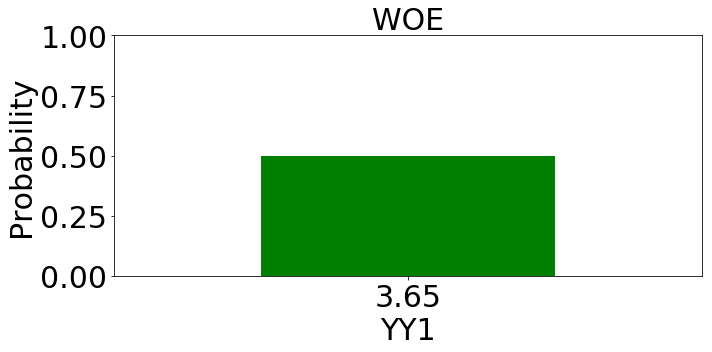

In [10]:
woev, numbin = iv_woe(dff, 'target', 'YY1')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'YY1', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-alternative.png', dpi=300)
plt.show()

# 20news groups

In [11]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Select four classes
categories = ['talk.politics.guns', 'rec.sport.baseball','comp.graphics']
# Load data set
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories)
# Select tfidf feature
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(newsgroups_train.data)

#Get array
a = vectors.toarray()
b = newsgroups_train.target
c = newsgroups_train.target_names
b=[str(x) for x in b]
#Transform target 
for i in range(0,1727):
    if b[i] == '0':
        b[i] = 'comp.graphics'
    if b[i] == '1':
        b[i] = 'rec.sport.baseball'
    if b[i] == '2':
        b[i] = 'talk.politics.guns'
        
for i in range(0,1727):
    if b[i] == 'comp.graphics':
        b[i] = 1
    else:
        b[i] = 0

#Get array
b = np.array(b)
a = np.c_[b,a]

import pandas as pd
df = pd.DataFrame(a)

list_=['target']
for i in range(0,30664):
    str(i)
    list_.append('w'+str(i))
    
df.columns = list_
#Specify the name of the features
#del list_[0]
features = list_[1:]
# Get the features
X = df[features].values
# Get the target
y = df['target'].values

from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = list_

-------------process continuous variable:w25698-------------
w25698
  var_name                   split_list  woe_list
0   w25698  (-INF,-0.23757976964380254] -0.136927
1   w25698  (-0.23757976964380254,+INF)  1.490537
2


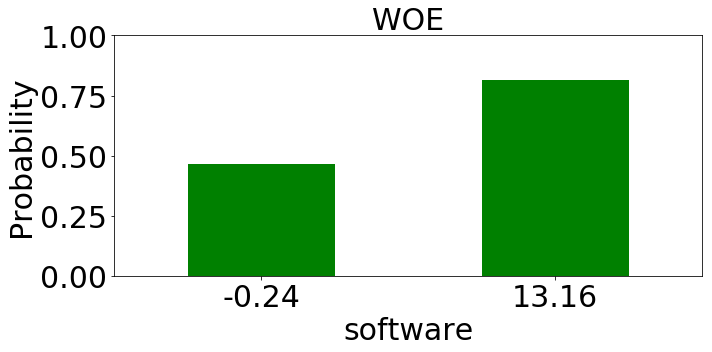

In [12]:
woev, numbin = iv_woe(dff, 'target', 'w25698')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'w25698', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-spambase.png', dpi=300)
plt.show()

# spambase

In [13]:
import pandas as pd

# Load the data
df = pd.read_csv('spambase.data', header=None)

# Specify the name of the columns
df.columns = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'target']

# Features
features = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']

#Specify the name of the features
# Get the features
X = df[features].values
# Get the target
y = df['target'].values

from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = ['target','word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']

----------process continuous variable:char_freq_!-----------
char_freq_!
      var_name                                   split_list  woe_list
0  char_freq_!                  (-INF,-0.32991229454180127] -1.480426
1  char_freq_!  (-0.32991229454180127,-0.23059683378296697] -0.106586
2  char_freq_!   (-0.23059683378296697,-0.0994023362373464]  0.549246
3  char_freq_!    (-0.0994023362373464,0.04527944610268377]  1.065306
4  char_freq_!     (0.04527944610268377,0.1781537236636081]  1.385852
5  char_freq_!      (0.1781537236636081,0.6747923332977541]  1.833647
6  char_freq_!                    (0.6747923332977541,+INF)  2.347262
7


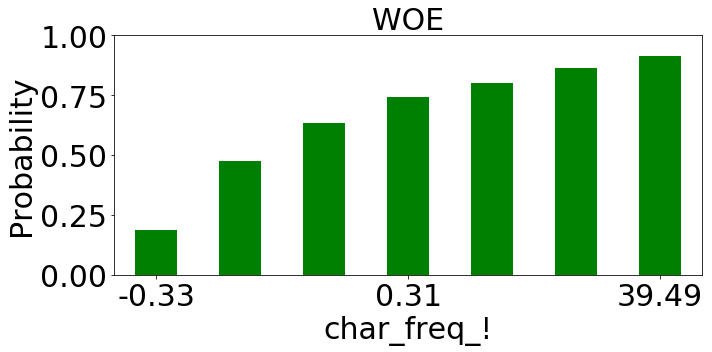

In [14]:
woev, numbin = iv_woe(dff, 'target', 'char_freq_!')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'char_freq_!', 0, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-spambase.png', dpi=300)
plt.show()

# MNIST

In [15]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('train.csv', header=None)

# Specify the name of the columns
list_=['target']
for i in range(0,784):
    str(i)
    list_.append('w'+str(i))
    
df.columns = list_
features = list_[1:]

# Get the features
X = df[features].values
# Get the target
y = df['target'].values

#Initialize a column
a=np.zeros([X.shape[0],1])

#Calculate the average of row
for i in range(0,28):
    b=np.mean(X[:,i*28:(i+1)*28],axis=1)
    a=np.c_[a,b]
    
#Calculate the average of column
n=0
for i in range(0,28):
    c=X[:,i]
    for j in range(28,784):
        if j%28==n:
            c=np.c_[c,X[:,j]]
    c=np.mean(c,axis=1)
    a=np.c_[a,c]
    n=n+1
    
#update X matrix    
X=a[:,1:58]

from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

for i in range(0,42000):
    if not y[i] == 1:
        y[i] = 0
        
        
dff = np.c_[y,X]

dff = pd.DataFrame(dff)

list_=['target']
for i in range(0,56):
    str(i)
    list_.append('w'+str(i))
    
dff.columns = list_

--------------process continuous variable:w41---------------
w41
  var_name   split_list      woe_list
0      w41  (-INF,+INF)  1.866946e-08
1


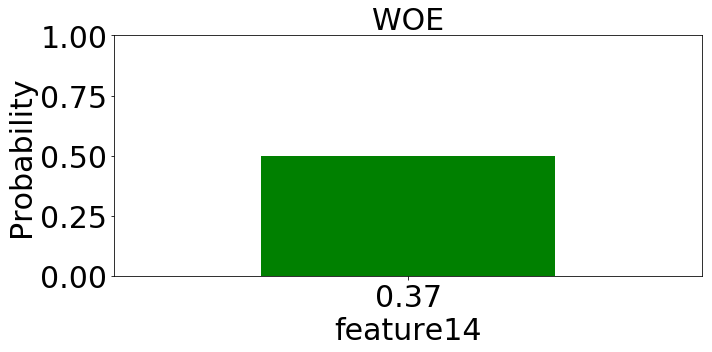

In [16]:
woev, numbin = iv_woe(dff, 'target', 'w41')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, 'w41', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-minist.png', dpi=300)
plt.show()

# CIFAR-10

In [3]:
import numpy as np
import random
import pandas as pd
import pickle
import platform
import os
 
#加载序列文件
def load_pickle(f):
    version=platform.python_version_tuple()#判断python的版本
    if version[0]== '2':
        return pickle.load(f)
    elif version[0]== '3':
        return pickle.load(f,encoding='latin1')
    raise ValueError("invalid python version:{}".format(version))

#处理原数据
def load_CIFAR_batch(filename):
    with open(filename,'rb') as f:
        datadict=load_pickle(f)
        X=datadict['data']
        Y=datadict['labels']
        #X=X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        #reshape()是在不改变矩阵的数值的前提下修改矩阵的形状,transpose()对矩阵进行转置
        Y=np.array(Y)
        return X,Y
        
        
#返回可以直接使用的数据集
def load_CIFAR10(ROOT):
    xs=[]
    ys=[]
    for b in range(1,6):
        f=os.path.join(ROOT,'data_batch_%d'%(b,))#os.path.join()将多个路径组合后返回
        X,Y=load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr=np.concatenate(xs)#这个函数用于将多个数组进行连接
    Ytr=np.concatenate(ys)
    del X,Y
    Xte,Yte=load_CIFAR_batch(os.path.join(ROOT,'test_batch'))
    return Xtr,Ytr,Xte,Yte


datasets='cifar-10-batches-py'
X_train,Y_train,X_test,Y_test=load_CIFAR10(datasets)


#get R,G,B array
XR = X_train[:,:1024]
XG = X_train[:,1024:2048]
XB = X_train[:,2048:3072]

XR = np.c_[Y_train, XR]
XG = np.c_[Y_train, XG]
XB = np.c_[Y_train, XB]


#get dataframe
df = pd.DataFrame(XR)

#name each pixel point
list_=['target']
for i in range(0,32):#row
    for j in range(0,32):#column
        list_.append(str(i)+'-'+str(j)+'R')

    
    
df.columns = list_
#Specify the name of the features
#del list_[0]
features = list_[1:]
# Get the features
X = df[features].values
# Get the target
y = df['target'].values

for i in range(0,50000):
    if y[i] == 5:
        y[i] = 11
    else:
        y[i] = 0
        
for i in range(0,50000):
    if y[i] == 11:
        y[i] = 1
        
from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

list_=['target']
for i in range(0,32):#row
    for j in range(0,32):#column
        list_.append(str(i)+'-'+str(j)+'R')

dff = np.c_[y,X]

dff = pd.DataFrame(dff)
dff.columns = list_

/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


-------------process continuous variable:16-16R-------------
16-16R
   var_name                                 split_list  woe_list
0    16-16R                 (-INF,-1.4686044521985133]  0.025127
1    16-16R  (-1.4686044521985133,-1.2044168316700654] -0.056014
2    16-16R  (-1.2044168316700654,-0.9567409374246454] -0.209960
3    16-16R  (-0.9567409374246454,-0.6595298643301414] -0.357749
4    16-16R  (-0.6595298643301414,-0.4283656963677493] -0.225480
5    16-16R  (-0.4283656963677493,-0.2797601598204973] -0.419545
6    16-16R  (-0.2797601598204973,0.18256817610428677] -0.234401
7    16-16R   (0.18256817610428677,0.4632675229157628] -0.023022
8    16-16R    (0.4632675229157628,0.7274551434442108]  0.164959
9    16-16R    (0.7274551434442108,0.9751310376896309]  0.064847
10   16-16R    (0.9751310376896309,1.2723421107841348]  0.293902
11   16-16R     (1.2723421107841348,1.652111815293779]  0.394461
12   16-16R                   (1.652111815293779,+INF)  0.564937
13


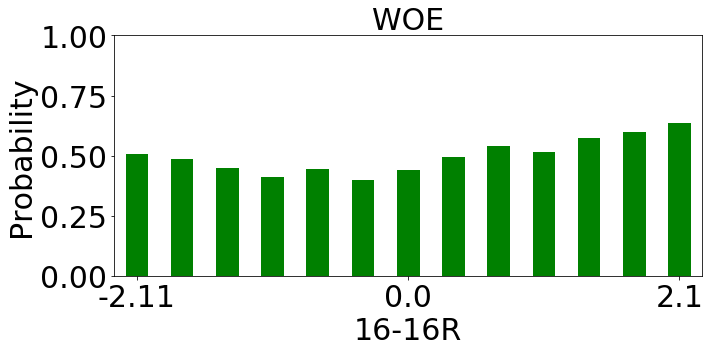

In [4]:
woev, numbin = iv_woe(dff, 'target', '16-16R')
swoe = sigmoid(woev)
#print(swoe)
plot_woe(numbin, swoe, '16-16R', 1, X)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/woe-cifar-10.png', dpi=300)
plt.show()